In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


What I want to find out
1. Do famous artists make their songs more popular?
2. Do songs with swearing do better than clean songs?
3. How has music changed over the years?

In [5]:
spotify_data = pd.read_csv('data/track_data_final.csv')

print("Dataset loaded successfully!")
print(f"Total tracks: {spotify_data.shape[0]}")
print(f"Total features: {spotify_data.shape[1]}")
print("\nFirst few rows:")
spotify_data.head()

Dataset loaded successfully!
Total tracks: 8778
Total features: 15

First few rows:


,track_id,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type
0,6pymOcrCnMuCWdgGVTvUgP,3,57,61,213173,False,Britney Spears,80.0,17755451.0,['pop'],325wcm5wMnlfjmKZ8PXIIn,The Singles Collection,2009-11-09,58,compilation
1,2lWc1iJlz2NVcStV5fbtPG,Clouds,1,67,158760,False,BUNT.,69.0,293734.0,['stutter house'],2ArRQNLxf9t0O0gvmG5Vsj,Clouds,2023-01-13,1,single
2,1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),11,63,225328,False,Taylor Swift,100.0,145396321.0,[],4hDok0OAJd57SGIT8xuWJH,Fearless (Taylor's Version),2021-04-09,26,album
3,7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,2,72,158463,True,Billie Eilish,90.0,118692183.0,[],0JGOiO34nwfUdDrD612dOp,Happier Than Ever,2021-07-30,16,album
4,0GLfodYacy3BJE7AI3A8en,Man Down,7,57,267013,False,Rihanna,90.0,68997177.0,[],5QG3tjE5L9F6O2vCAPph38,Loud,2010-01-01,13,album


In [6]:
spotify_data.describe()

,track_number,track_popularity,track_duration_ms,artist_popularity,artist_followers,album_total_tracks
count,8778.000000,8778.000000,8778.000000,8774.000000,8.774000e+03,8778.000000
mean,5.749487,52.232855,210157.791866,69.954981,2.435487e+07,13.779790
std,6.017938,24.075221,63326.841454,19.532783,3.813769e+07,11.797943
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,1.000000,39.000000,173921.250000,60.000000,5.152768e+05,6.000000
50%,4.000000,58.000000,207276.000000,74.000000,6.272266e+06,13.000000
75%,9.000000,71.000000,239693.250000,84.000000,3.055055e+07,17.000000
max,102.000000,100.000000,811077.000000,100.000000,1.455421e+08,181.000000


In [7]:
print("Missing values check:")
missing = spotify_data.isnull().sum()
missing_percentage = (missing / len(spotify_data)) * 100

summary = pd.DataFrame({
    'Missing': missing,
    'Percent': missing_percentage
})
summary = summary[summary['Missing'] > 0]

if len(summary) == 0:
    print("No missing values")
else:
    print(summary)

Missing values check:
                   Missing   Percent
track_name               2  0.022784
artist_name              4  0.045568
artist_popularity        4  0.045568
artist_followers         4  0.045568
artist_genres            4  0.045568
album_name               2  0.022784


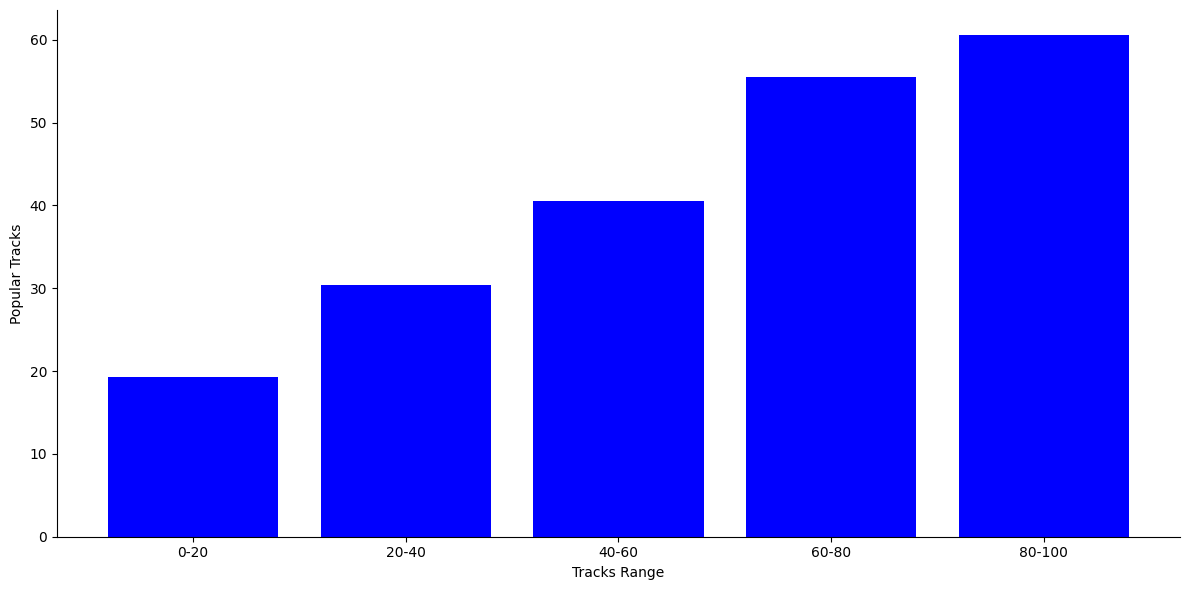

In [ ]:
plt.figure(figsize=(12, 6))

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
spotify_data['artist_pop_range'] = pd.cut(spotify_data['artist_popularity'], bins=bins, labels=labels)

avg_by_range = spotify_data.groupby('artist_pop_range')['track_popularity'].mean()

plt.bar(range(len(avg_by_range)), avg_by_range.values, color='blue')
plt.xticks(range(len(avg_by_range)), avg_by_range.index)
plt.xlabel('Tracks Range')
plt.ylabel('Popular Tracks')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

correlation = spotify_data[['artist_popularity', 'track_popularity']].corr().iloc[0, 1]



I found out that some songs from really famous artists get around 70 popularity points. But songs from not famous artists  only get around 30 points.

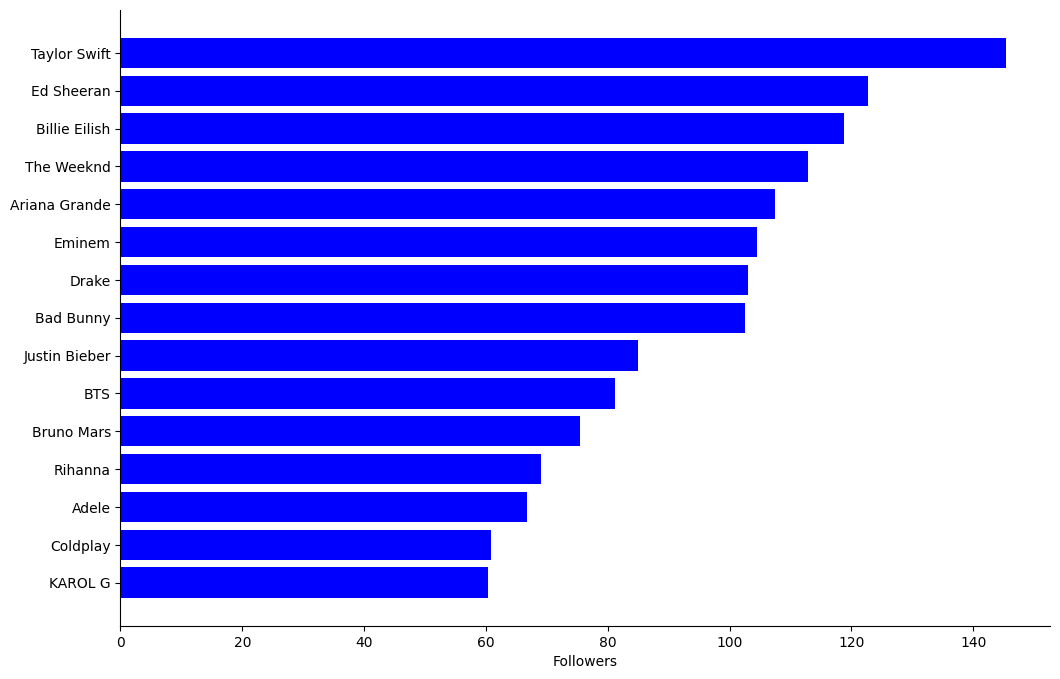

In [235]:
top_artists = spotify_data.groupby('artist_name').agg({
    'artist_followers': 'first'
}).sort_values('artist_followers', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(top_artists)), top_artists['artist_followers'] / 1e6, color='blue')
ax.set_yticks(range(len(top_artists)))
ax.set_yticklabels(top_artists.index)
ax.set_xlabel('Followers')
ax.invert_yaxis()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

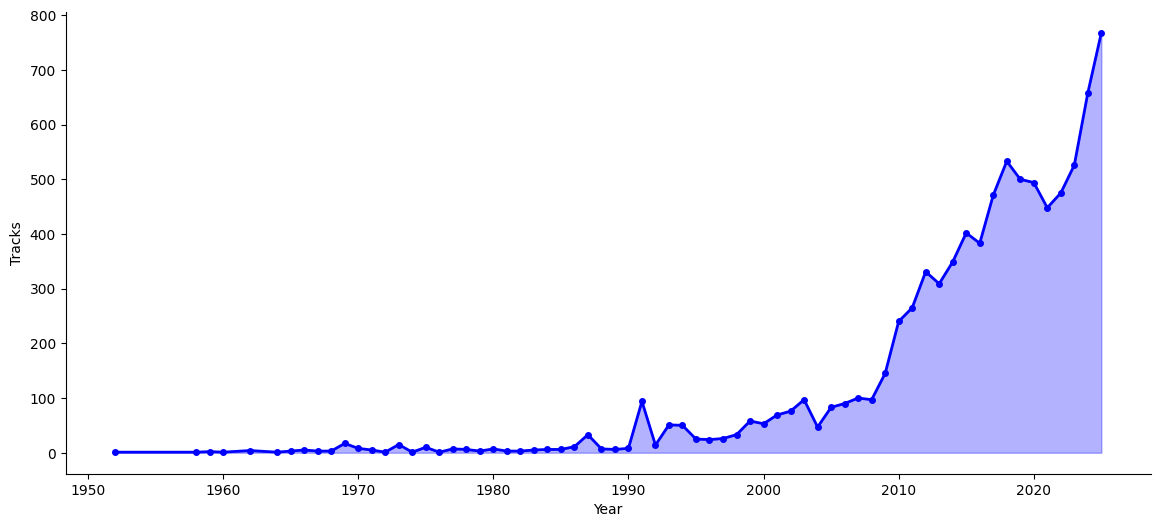

In [ ]:
tracks_by_year = spotify_data.groupby('release_year').size()

plt.figure(figsize=(14, 6))
plt.plot(tracks_by_year.index, tracks_by_year.values, marker='o', linewidth=2, markersize=4, color='blue')
plt.fill_between(tracks_by_year.index, tracks_by_year.values, alpha=0.3, color='blue')
plt.xlabel('Year')
plt.ylabel('Tracks')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

I found out Taylor Swift has over 145 million followers! These mega-famous artists have huge fanbases that will listen to whatever they put out.

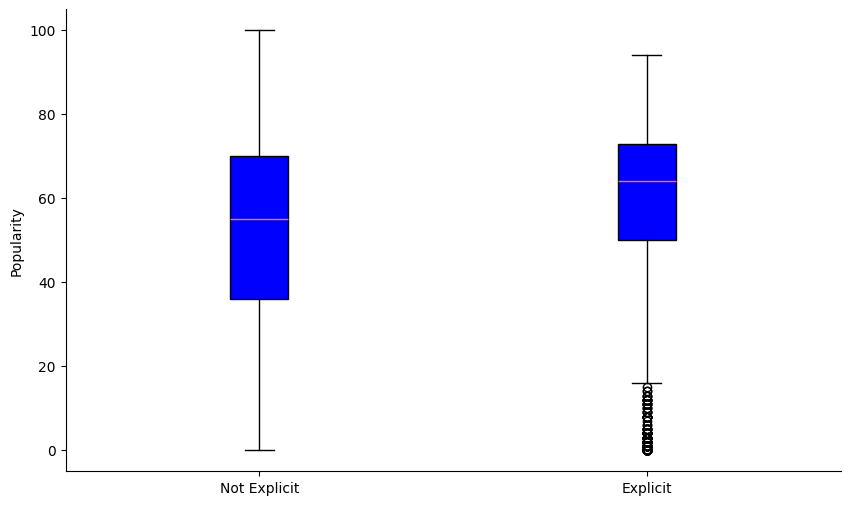

In [ ]:
clean_tracks = spotify_data[spotify_data['explicit'] == False]['track_popularity']
explicit_tracks = spotify_data[spotify_data['explicit'] == True]['track_popularity']
data_to_plot = [clean_tracks, explicit_tracks]

plt.figure(figsize=(10, 6))
boxes = plt.boxplot(data_to_plot, labels=['Not Explicit', 'Explicit'], patch_artist=True)
for box in boxes['boxes']:
    box.set_facecolor('blue')
plt.ylabel('Popularity')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

I found way more songs are coming out now. Since 2010, it just keeps going up. Streaming made it super easy for anyone to release music.

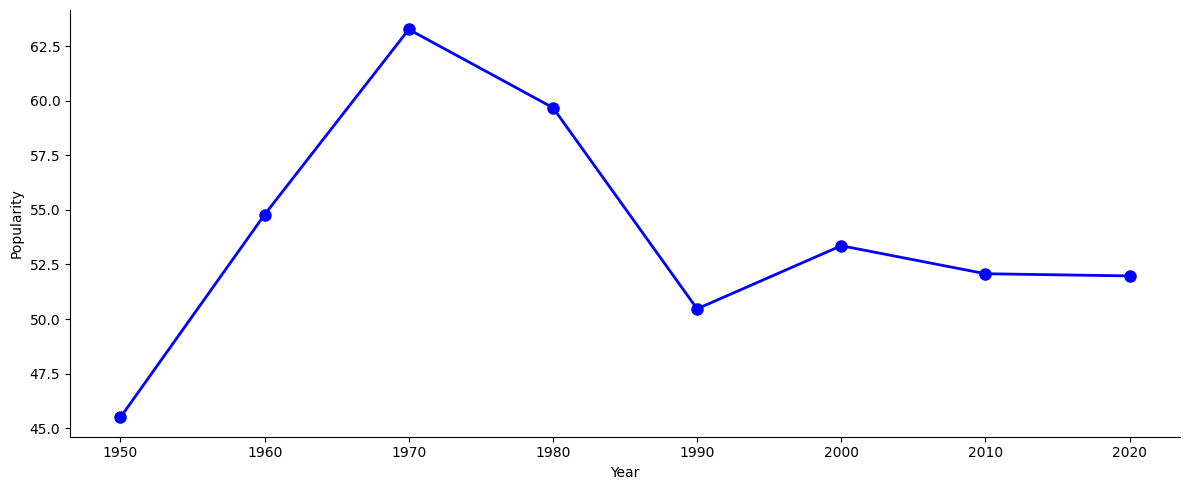

In [243]:
stats_by_decade = spotify_data.groupby('decade').agg({
    'track_popularity': 'mean',
    'track_id': 'count'
}).reset_index()
stats_by_decade.columns = ['decade', 'avg_popularity', 'track_count']

plt.figure(figsize=(12, 5))

plt.plot(stats_by_decade['decade'], stats_by_decade['avg_popularity'], 
         color='blue', marker='o', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

I found out explicit songs are a bit more popular. People seem to like these types of songs.

In [ ]:
numeric_cols = ['track_popularity', 'artist_popularity', 'artist_followers', 
                'track_duration_ms', 'album_total_tracks', 'track_age']

correlations = spotify_data[numeric_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=correlations.values,
    x=correlations.columns,
    y=correlations.columns,
    colorscale='Blues',
    zmid=0,
    text=correlations.values,
    texttemplate='%{text:.2f}',
    textfont={"size": 10},
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    width=800,
    height=700,
    xaxis_title="",
    yaxis_title="",
    xaxis={'side': 'bottom'}
)

fig.show()


I found out that songs from the 1970s look super popular but that's because only the really good old songs are still around

In [ ]:

machine_learning_data = spotify_data[['track_popularity', 'artist_popularity', 'artist_followers', 
                      'track_duration_ms', 'explicit', 'album_total_tracks', 
                      'album_type', 'track_age']].copy()

machine_learning_data = machine_learning_data.dropna()

feature_columns = machine_learning_data.drop('track_popularity', axis=1) 
target_column = machine_learning_data['track_popularity']  


I found out the artist's popularity is the biggest thing that matters. How long the song is or how old it is doesn't matter nearly as much

In [250]:
training_features, testing_features, training_target, testing_target = train_test_split(
    feature_columns, target_column, test_size=0.2, random_state=42)

In [249]:
numeric_features = ['artist_popularity', 'artist_followers', 'track_duration_ms', 
                    'album_total_tracks', 'track_age']
categorical_features = ['explicit', 'album_type']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [248]:

linear_regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_regression_pipeline.fit(training_features, training_target)

predicted_popularity_linear = linear_regression_pipeline.predict(testing_features)

root_mean_squared_error_linear = np.sqrt(mean_squared_error(testing_target, predicted_popularity_linear))
mean_absolute_error_linear = mean_absolute_error(testing_target, predicted_popularity_linear)
r_squared_score_linear = r2_score(testing_target, predicted_popularity_linear)


I found out the Linear Regression model can predict about 27% of a song's popularity

---
Here is what I found


How popular the artist is matters way more than the song itself

Explicit songs get about 57% of popularity while clean songs get about 50%. People seem to like the explicit songs

Songs from the 1970s have high popularity scores

After 2010, many songs get released every year